In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pycaret.classification import *

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
df_trans = pd.read_csv('dh_transactions.csv')
df_trans.head(3)

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0


In [3]:
# remove outliner
def filter_outliner(df, column_name):
    q_low = df[column_name].quantile(0.0003) # mean-3sd
    q_hi  = df[column_name].quantile(0.9997) # mean+3sd
    df_filtered = df[(df[column_name] <= q_hi) & (df[column_name] >= q_low)]
    return df_filtered

# before removed 5,197,681 row
# after removed 5,184,441 row

df_trans = filter_outliner(df_trans, 'units')
# df_trans = df_trans.loc[(df_trans['day']<=365) & (df_trans['dollar_sales']>0)]
df_trans = df_trans.loc[df_trans['dollar_sales']>0]
df_trans = df_trans.drop_duplicates()
df_trans.head(3)

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0


In [4]:
df_trans_y1 = df_trans.loc[df_trans['week']<=52]
df_trans_y1.head(3)

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0


In [5]:
df_trans_y2_q1 = df_trans.loc[(df_trans['week']>52) & (df_trans['week']<=65), ['household']].reset_index(drop=True)
df_trans_y2_q1['purchase'] = 1
df_trans_y2_q1.head(3)

,household,purchase
0,18719,1
1,18719,1
2,280936,1


In [6]:
df_sumspend = df_trans_y1.groupby(['household'])[['dollar_sales']].apply('sum').reset_index()
df_sumspend.columns = ['household', 'total_spending']
df_sumspend.head(3)

,household,total_spending
0,1,10.48
1,2,130.44
2,3,5.28


In [7]:
df_countbkt = df_trans_y1.groupby('household')[['basket']].nunique().reset_index()
df_countbkt.columns = ['household', 'bkt_count']
df_countbkt.head(3)

,household,bkt_count
0,1,5
1,2,37
2,3,1


In [8]:
df_nweek = df_trans_y1.groupby('household')[['week']].nunique().reset_index()
df_nweek.head(3)

,household,week
0,1,5
1,2,31
2,3,1


In [9]:
df_rec = df_trans_y1.groupby('household')[['day']].max().reset_index()
df_rec['day'] = 365-df_rec['day']
df_rec.columns = ['household', 'recency']
# df_rec['recency'] = df_rec['recency'].rank(ascending=False)
# df_rec['recency'] = scaler.fit_transform(df_rec[['recency']])
df_rec.head(3)

,household,recency
0,1,20
1,2,6
2,3,43


In [10]:
df_final = pd.merge(df_sumspend, df_countbkt, on='household')
dfname = [df_nweek, df_rec]

for df in dfname:
    df_final = pd.merge(df_final, df, on='household')

df_final = pd.merge(df_final, df_trans_y2_q1, on='household', how='left')
df_final.head(3)

,household,total_spending,bkt_count,week,recency,purchase
0,1,10.48,5,5,20,1.0
1,2,130.44,37,31,6,1.0
2,2,130.44,37,31,6,1.0


In [11]:
df_final = df_final.drop_duplicates().reset_index(drop=True)
df_final = df_final.drop(columns='household')
df_final['purchase'] = df_final['purchase'].fillna(0)
df_final.head(3)

,total_spending,bkt_count,week,recency,purchase
0,10.48,5,5,20,1.0
1,130.44,37,31,6,1.0
2,5.28,1,1,43,0.0


In [12]:
df_final.purchase.value_counts()

0.0    208792
1.0    155252
Name: purchase, dtype: int64

In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364044 entries, 0 to 364043
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   total_spending  364044 non-null  float64
 1   bkt_count       364044 non-null  int64  
 2   week            364044 non-null  int64  
 3   recency         364044 non-null  int64  
 4   purchase        364044 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 13.9 MB


In [14]:
df_final.corr()['purchase']

total_spending    0.368486
bkt_count         0.422562
week              0.435441
recency          -0.389902
purchase          1.000000
Name: purchase, dtype: float64

In [15]:
X = df_final.drop(columns='purchase')
y = df_final['purchase']

In [16]:
scaler = MinMaxScaler()

for col in list(X.columns):
    X[col] = scaler.fit_transform(X[[col]])

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Assuming you have your features X and target variable y

# Create a random forest classifier
rf_classifier = RandomForestClassifier()

# Fit the model on your data
rf_classifier.fit(X, y)

# Obtain the feature importance
feature_importance = rf_classifier.feature_importances_

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importance
print(importance_df)

          Feature  Importance
0  total_spending    0.561557
3         recency    0.214265
2            week    0.144368
1       bkt_count    0.079810


In [18]:
s = setup(df_final, target = 'purchase', session_id = 123, train_size = 0.8)

,Description,Value
0,Session id,123
1,Target,purchase
2,Target type,Binary
3,Original data shape,"(364044, 5)"
4,Transformed data shape,"(364044, 5)"
5,Transformed train set shape,"(291235, 5)"
6,Transformed test set shape,"(72809, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [19]:
compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:12:08
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,SVM - Linear Kernel


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7336,0.7889,0.5709,0.7450,0.6464,0.4387,0.4487,0.4660
nb,Naive Bayes,0.7113,0.7794,0.4347,0.7955,0.5622,0.3733,0.4113,0.1040
knn,K Neighbors Classifier,0.6982,0.7338,0.5961,0.6624,0.6275,0.3750,0.3765,0.3970
dt,Decision Tree Classifier,0.6605,0.6342,0.5588,0.6116,0.5840,0.2982,0.2990,0.2220


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7364,0.7936,0.5955,0.7360,0.6584,0.4477,0.4543,3.149
lightgbm,Light Gradient Boosting Machine,0.7363,0.7935,0.5980,0.7344,0.6592,0.4478,0.4541,0.313
ada,Ada Boost Classifier,0.7337,0.7905,0.6017,0.7270,0.6584,0.4434,0.4487,1.225
lr,Logistic Regression,0.7336,0.7889,0.5709,0.7450,0.6464,0.4387,0.4487,0.523
lda,Linear Discriminant Analysis,0.7330,0.7872,0.5542,0.7546,0.6391,0.4350,0.4481,0.131
ridge,Ridge Classifier,0.7329,0.0000,0.5528,0.7553,0.6383,0.4345,0.4478,0.112
nb,Naive Bayes,0.7113,0.7794,0.4347,0.7955,0.5622,0.3733,0.4113,0.097
svm,SVM - Linear Kernel,0.7022,0.0000,0.5925,0.7184,0.6236,0.3846,0.4110,2.117
qda,Quadratic Discriminant Analysis,0.7002,0.7679,0.4209,0.7726,0.5449,0.3491,0.3850,0.108
knn,K Neighbors Classifier,0.6982,0.7338,0.5961,0.6624,0.6275,0.3750,0.3765,0.399


In [ ]:
model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7366,0.7925,0.5917,0.7386,0.6570,0.4474,0.4547
1,0.7391,0.7961,0.5989,0.7397,0.6619,0.4533,0.4600
2,0.7368,0.7950,0.5909,0.7396,0.6569,0.4478,0.4552
3,0.7332,0.7902,0.5906,0.7321,0.6538,0.4408,0.4476
4,0.7375,0.7981,0.5962,0.7379,0.6595,0.4498,0.4566
5,0.7370,0.7906,0.5964,0.7367,0.6592,0.4489,0.4555
6,0.7346,0.7894,0.6021,0.7284,0.6593,0.4451,0.4505
7,0.7369,0.7951,0.5948,0.7374,0.6585,0.4484,0.4553
8,0.7391,0.7984,0.6012,0.7384,0.6628,0.4536,0.4600


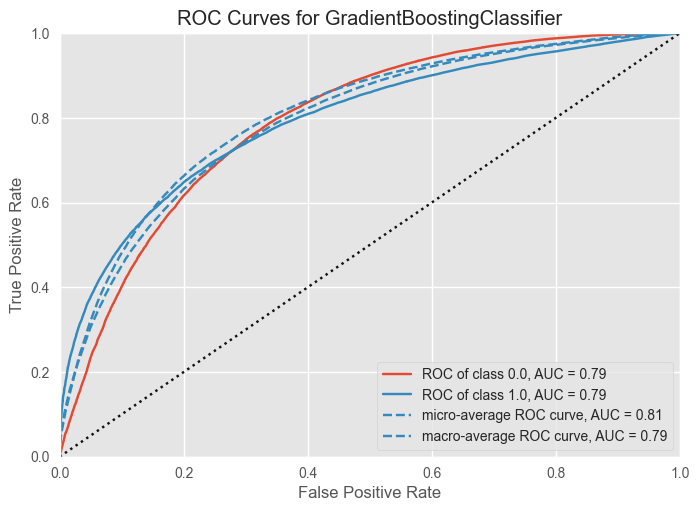

In [ ]:
plot_model(model)

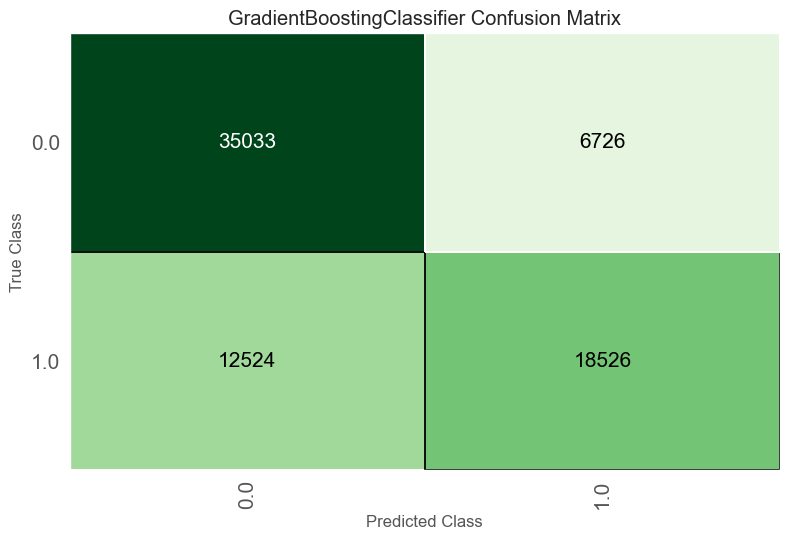

In [ ]:
plot_model(model, 'confusion_matrix')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7342848666644691

In [ ]:
# test model
df_trans_y1_q2 = df_trans.loc[(df_trans['week']>13) & (df_trans['week']<=65), ['household']].reset_index(drop=True)
df_trans_y1_q2.head(3)

,household,purchase
0,18719,1
1,18719,1
2,280936,1
